# Random forest

## Data preprocessing steps

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

In [54]:
# loading the transformed data

train = pd.read_csv('data/train_transformed.csv').reset_index(drop=True)
validation = pd.read_csv('data/validation_transformed.csv')

train = train.drop(columns='Unnamed: 0')
validation = validation.drop(columns='Unnamed: 0')

In [55]:
train.columns

Index(['CompetitionDistance', 'Sales', 'Store_cat_h', 'Store_cat_l',
       'Store_cat_m', 'Store_cat_vh', 'StateHoliday_0',
       'StateHoliday_Christmas', 'StateHoliday_Easter', 'StateHoliday_Public',
       'SchoolHoliday_0.0', 'SchoolHoliday_1.0', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'Promo_0.0',
       'Promo_1.0'],
      dtype='object')

In [58]:
ytrain = train['Sales']
Xtrain = train.drop(columns = 'Sales')

yval = validation['Sales']
Xval = validation.drop(columns = 'Sales')

## Run Random Forest with all features for base line and check feature importance

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [57]:
# metric 

def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [59]:
# base line Random Forest

base_rf = RandomForestRegressor(random_state=42)
base_rf.fit(Xtrain, ytrain)

pred_train = base_rf.predict(Xtrain)
pred_val = base_rf.predict(Xval)

base_train = metric(np.array(pred_train), np.array(ytrain))
base_val = metric(np.array(pred_val), np.array(yval))

AssertionError: 

In [62]:
print(f'Metric train {base_train}')
print(f'Metric val {base_val}')

Metric train 22.3860988112353
Metric val 38.704869808136024


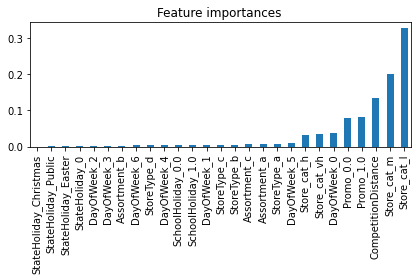

In [63]:
# feature importance 
importances = base_rf.feature_importances_

forest_importances = pd.Series(importances, index=Xtrain.columns)
std = np.std([base_rf.feature_importances_ for tree in base_rf.estimators_], axis=0)
forest_importances = forest_importances.sort_values()

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances ")
fig.tight_layout()

## About features: missing week of the year?, store ID in other way?
### From previous, remove the feature with less importance 

In [64]:
rem_col = {
  'rem_com_promo': ['Promo_0.0', 'Promo_1.0'],
  'rem_holidays': ['Promo_0.0', 'Promo_1.0', 'StateHoliday_0', 'StateHoliday_Christmas', 'StateHoliday_Easter', 'StateHoliday_Public',
       'SchoolHoliday_0.0', 'SchoolHoliday_1.0']
}



In [66]:
len(rem_col)

2

In [79]:
list(rem_col.keys())

['rem_com_promo', 'rem_holidays']

In [52]:
# Testing performance removing different set of features

In [81]:
metrics_all = []
dd = list(rem_col.keys()) 

for i in range(len(rem_col)):
    model = RandomForestRegressor(random_state=42)
    model.fit(Xtrain.drop(columns=rem_col[dd[i]]), ytrain)

    pred_train_new = model.predict(Xtrain.drop(columns=rem_col[dd[i]]))
    pred_val_new = model.predict(Xval.drop(columns=rem_col[dd[i]]))

    metrics_all.append(metric(np.array(pred_val_new), np.array(yval)))
    
    

In [82]:
# Metrics for different features combinations

for i in range(len(rem_col)):
    print(f'Metric for {i} is {metrics_all[i]}')


Metric for 0 is 37.74809260092368
Metric for 1 is 23.591985647360225


### It seems better to remove the holidays

In [84]:
# Grid search over selected feature combination

n_estimators = [int(x) for x in np.linspace(start=120, stop=130, num=2)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 50, num=5)]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}


model_RFR = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=model_RFR,
                               param_distributions=grid,
                               n_iter=5,  # try 5 models
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(Xtrain.drop(columns=rem_col[dd[1]]), ytrain)
best_random = rf_random.best_estimator_
print(f'Best model is {best_random}')
best_metric = metric(np.array(best_random.predict(Xval.drop(columns=rem_col[dd[1]]))), np.array(yval))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best model is RandomForestRegressor(max_depth=38, max_features='sqrt', n_estimators=130)


In [85]:
# the metric is almost the same as with the default parameters
print(f'Metric with best forest is {best_metric}')

Metric with best forest is 23.577647791245695
